In [24]:
import graphinglib as gl
import scavenger as sg
import numpy as np
from shapely import Polygon
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline


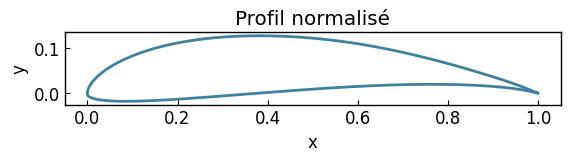

In [25]:
# Profile data as dataframes with columns [x, y]
profile_1_data = sg.read_csv("Profile1.csv")
profile_2_data = sg.read_csv("Profile2.csv")
profile_full_data = sg.read_csv("profile.csv")

# Number of points for interpolation
num_points = 1000

# Prepare original data points
x = profile_full_data['x'].values
y = profile_full_data['y'].values

# Parameterize the data by arc length
t = np.zeros(x.shape)
t[1:] = np.sqrt((x[1:] - x[:-1])**2 + (y[1:] - y[:-1])**2).cumsum()
t_total = t[-1]
spline_t = np.linspace(0, t_total, num_points)

# Create spline functions for x and y with 'not-a-knot' condition, which is the default
spline_x = CubicSpline(t, x)
spline_y = CubicSpline(t, y)

# Generate interpolated points again
interp_x = spline_x(spline_t)
interp_y = spline_y(spline_t)

# Use these points to define a new polygon
interp_shape = Polygon(np.column_stack((interp_x, interp_y)))

# Get x and y arrays for the new polygon
interp_x = interp_shape.exterior.xy[0]
interp_y = interp_shape.exterior.xy[1]

# Plot the interpolated shape
curve = gl.Curve(interp_x, interp_y)
fig = gl.Figure(x_label='x', y_label='y', title='Profil normalisé')
fig.add_elements(curve)
fig._prepare_figure()
fig._axes.set_aspect('equal')
fig._figure



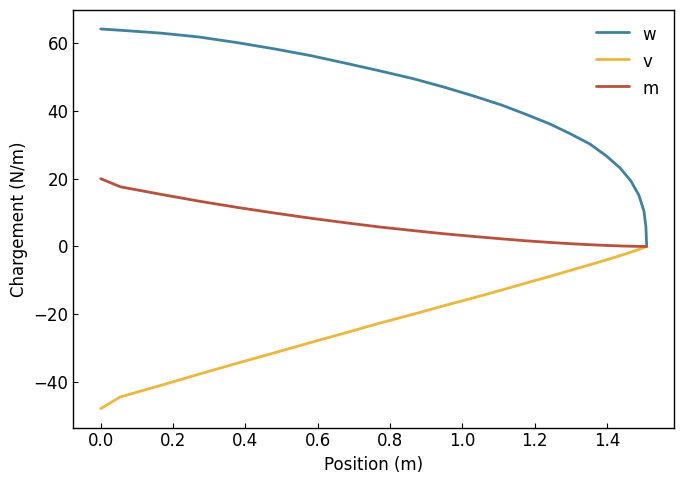

In [26]:
lift_data = sg.read_csv("lift.csv")
# Name the columns of the dataframe to Position and Chargement
lift_data.columns = ['Position', 'Chargement']
curve = gl.Curve(lift_data['Position'], lift_data['Chargement'], label="w")
v = curve.create_integral_curve(label="v")
v = v - max(v)
v.label = "v"
m = v.create_integral_curve(label="m")
m = m - min(m)
m.label = "m"
fig = gl.Figure(size=(7, 5), x_label='Position (m)', y_label='Chargement (N/m)')
fig.add_elements(curve, v, m)
plt.close()
fig.show()

In [12]:
from pydantic import BaseModel, validate_call, Field
from typing import Annotated

# Définir les classes pour les propriétés des ailes
class BaseAile(BaseModel):
    @property
    def epaisseur(self):
        return 0.35 * 10**(-3)

    @validate_call
    def c(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        slope = (0.34 - 0.606) / 1.51
        return 0.606 + slope * position_l
    
    def surface_profile(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 0.0851101 * self.c(position_l) ** 2
    
    def perimetre_profile(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 2.0654 * self.c(position_l)


class RevAile(BaseAile):
    @property
    def E(self):
        return 64e9
    
    @property
    def G_xy(self):
        return 5e9
    
    @property
    def nu_xy(self):
        return 0.047

    @property
    def c_rupture_traction_x_et_y(self):
        return 800e6
    
    @property
    def c_rupture_compression_x_et_y(self):
        return 700e6
    
    @property
    def c_rupture_cisaillement_dans_plan(self):
        return 130e6
    
    def centroide_x(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 0.49251 * self.c(position_l)

    def centroide_y(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 0.046128 * self.c(position_l)
    
    def I_x(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 0.0051752 * self.c(position_l) ** 3 * self.epaisseur
    
    def I_y(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 0.17878 * self.c(position_l) ** 3 * self.epaisseur
    
    def I_xy(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return -0.0010805 * self.c(position_l) ** 3 * self.epaisseur


class CoeurAile(BaseAile):
    @property
    def E(self):
        return 16e6
    
    @property
    def poisson(self):
        return 0.1
    
    @property
    def c_rupture_traction(self):
        return 300e3
    
    @property
    def limite_elasticite_compression(self):
        return 46e3
    
    @property
    def c_rupture_cisaillement_dans_plan(self):
        return 300e3
    
    def I_x(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 9.8490e-5 * self.c(position_l) ** 4
    
    def I_y(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 4.3219e-3 * self.c(position_l) ** 4
    
    def I_xy(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 8.3263e-5 * self.c(position_l) ** 4

    def centroide_x(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 0.40575 * self.c(position_l)
    
    def centroide_y(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 0.053017 * self.c(position_l)


In [13]:
rev_aile = RevAile()
coeur_aile = CoeurAile()

rev_aile.surface_profile(0.3)

0.02604177449733027